# State Estimation, Forward Only

In this demo, we will perform state estimation in a state-space model (SSM) using the ForneyLab toolbox. The goal is to filter noisy scalar observations.

Let `x_t_min` be the previous state of the system, `x_t` the current state, `u` a constant system input and `y_t` the noisy observation of `x_t`:

\begin{align*}
    u &= 1\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u\\
    y_t &= x_t + n_t
\end{align*}

We further assume that the observations are corrupted by i.i.d. Gaussian noise with variance `v`. 

The SSM can be represented as a Forney-style factor graph:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

The full generative model is obtained by chaining multiple of these sections. For online estimation it suffices to define only a single section.

In [4]:
# Data
n_samples = 100
x = [t for t=1:n_samples] # True state
y = x + sqrt(200.0)*randn(n_samples); # Noisy observations of state

# Build

In [1]:
using ForneyLab

g = FactorGraph()

# Noise variance
v = constant(200.0, id=:v) # variance of the observation noise

# Prior statistics
m_x_t_min = Variable(id=:m_x_t_min)
v_x_t_min = Variable(id=:v_x_t_min)

# State prior
x_t_min ~ GaussianMeanVariance(m_x_t_min, v_x_t_min)

# Transition and observation model
u   = constant(1.0)
n_t ~ GaussianMeanVariance(constant(0.0), v) # zero-mean gaussian observation noise
x_t = x_t_min + u
y_t = x_t + n_t

# Placeholder for prior statistics
placeholder(m_x_t_min, :m_x_t_min)
placeholder(v_x_t_min, :v_x_t_min)

# Data placeholder
placeholder(y_t, :y_t)

# Name variable for ease of lookup
x_t.id = :x_t;

# Schedule

Now that the factor graph is complete, we can generate an algorithm that computes the current state from the previous state prior and the currently observed data point.

In [2]:
algo = sumProductAlgorithm(x_t) # Figure out a schedule and compile to Julia code

println(algo)

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(4))

messages[1] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=data[:m_x_t_min]), Message(Univariate, PointMass, m=data[:v_x_t_min]))
messages[2] = ruleSPAdditionOutVGP(nothing, messages[1], Message(Univariate, PointMass, m=1.0))
messages[3] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=200.0))
messages[4] = ruleSPAdditionIn1PVG(Message(Univariate, PointMass, m=data[:y_t]), nothing, messages[3])

marginals[:x_t] = messages[2].dist * messages[4].dist

return marginals

end


We can visualize the factor graph for the model and the schedule

In [3]:
ForneyLab.draw(g, schedule=schedule)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3092746750525801521 -->
 3092746750525801521 
 
 placeholder_v_x_t_min 
 
<!-- 7676958754515320015 -->
 7676958754515320015 
 
 𝒩 
 gaussian_1 
 
<!-- 3092746750525801521--7676958754515320015 -->
 3092746750525801521--7676958754515320015 
 
 3 v 
 1 out 
 
<!-- 10101085988769116471 -->
 10101085988769116471 
 
 + 
 addition_1 
 
<!-- 4175056682713217817 -->
 4175056682713217817 
 
 clamp_1 
 
<!-- 10101085988769116471--4175056682713217817 -->
 10101085988769116471--4175056682713217817 
 
 1 out 
 3 in2 
 
<!-- 10101085988769116471--7676958754515320015 -->
 10101085988769116471--7676958754515320015 
 
 1 out 
 (1) 
 2 in1 
 
<!-- 1838390165432928103 -->
 1838390165432928103 
 
 v 
 
<!-- 17254212882414524375 -->
 17254212882414524375 
 
 𝒩 
 gaussian_2 
 
<!-- 17254212882414524375--1838390165432928103 -->
 17254212882414524375--1838390165432928103 
 
 1 out 
 3 v 
 
<!-- 8489592826682478803 -->
 8489592826682478803 
 
 clamp_2 
 
<!-- 17254212882414524375--8489592826682478803 -->
 17254212882414524375--8489592826682478803 
 
 1 out 
 2 m 
 
<!-- 18323628740544214088 -->
 18323628740544214088 
 
 placeholder_m_x_t_min 
 
<!-- 18323628740544214088--7676958754515320015 -->
 18323628740544214088--7676958754515320015 
 
 2 m 
 1 out 
 
<!-- 4164911188156071005 -->
 4164911188156071005 
 
 placeholder_y_t 
 
<!-- 8654521044090013497 -->
 8654521044090013497 
 
 + 
 addition_2 
 
<!-- 4164911188156071005--8654521044090013497 -->
 4164911188156071005--8654521044090013497 
 
 1 out 
 1 out 
 
<!-- 8654521044090013497--10101085988769116471 -->
 8654521044090013497--10101085988769116471 
 
 1 out 
 (2) 
 2 in1 
 (4) 
 
<!-- 8654521044090013497--17254212882414524375 -->
 8654521044090013497--17254212882414524375 
 
 1 out 
 (3) 
 3 in2

# Infer

All set. Now we apply the filter by recurively applying the forward algorithm to the data. 

In [5]:
# Define algorithm
eval(parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
v_x_0 = 1000.0

m_x = Vector{Float64}(n_samples)
v_x = Vector{Float64}(n_samples)

m_x_t_min = m_x_0
v_x_t_min = v_x_0
for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t       => y[t],
                :m_x_t_min => m_x_t_min,
                :v_x_t_min => v_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x[t] = mean(marginals[:x_t])
    v_x[t] = var(marginals[:x_t])
    
    # Prepare statistics for next step
    m_x_t_min = m_x[t]
    v_x_t_min = v_x[t]
end

# Results

That was easy!
Let's plot the filter output (mean and standard deviation of `x_t`) together with the noisy observations to see if it worked.

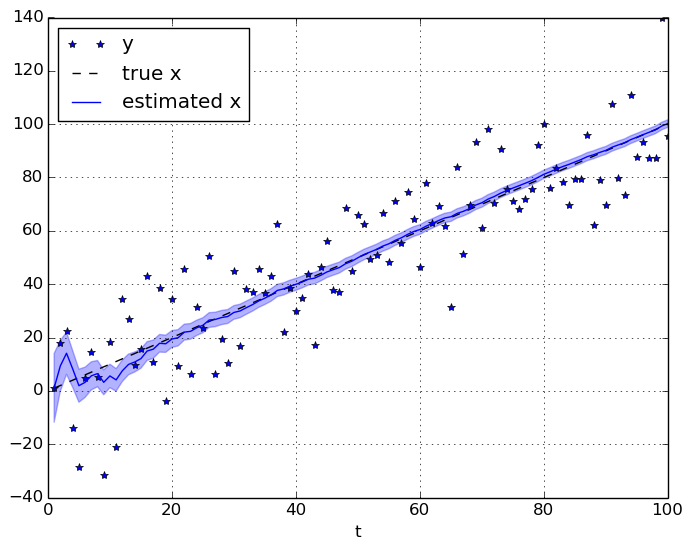

In [9]:
using PyPlot

plot(collect(1:n_samples), y, "b*", label="y")
plot(collect(1:n_samples), x, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt(v_x), m_x+sqrt(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");